In [ ]:
!apt update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-2.4.0/spark-2.4.0-bin-hadoop2.7.tgz
!tar -xvf spark-2.4.0-bin-hadoop2.7.tgz
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.0-bin-hadoop2.7"
import findspark
findspark.init()

In [2]:
from google.colab import drive
drive.mount("/content/gdrive")
%cd '/content/gdrive/MyDrive/LDS9_K265_TranHoangBach/Week_2/data_day_4'

Mounted at /content/gdrive
/content/gdrive/MyDrive/LDS9_K265_TranHoangBach/Week_2/data_day_4


In [3]:
from pyspark import SparkContext
from pyspark.conf import SparkConf
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import seaborn as sb
from pyspark.sql.functions import mean, stddev, col, log
from pyspark.sql.functions import to_date, dayofweek, to_timestamp
from pyspark.sql import types 
from pyspark.sql.functions import col, udf
from datetime import datetime
from pyspark.sql.types import DateType
from pyspark.sql.functions import year, month
from pyspark.sql.functions import dayofmonth, weekofyear
from pyspark.sql.functions import split, explode
from pyspark.sql.functions import coalesce, first, lit
from pyspark.ml.feature import Binarizer
from pyspark.ml.feature import Bucketizer
from pyspark.ml.feature import OneHotEncoder, StringIndexer
from pyspark.sql.functions import regexp_extract, col

In [4]:
def min_max_scaler(df, cols_to_scale):
    # Takes a dataframe and list of columns to minmax scale. Returns a dataframe.
    for col in cols_to_scale:
        # Define min and max values and collect them
        max_values = df.agg({col: 'max'}).collect()[0][0]
        min_values = df.agg({col: 'min'}).collect()[0][0]
        new_column_name = 'scaled_' + col
        # Create a new column based off the scaled data
        df = df.withColumn(new_column_name, 
                      (df[col] - min_values) / (max_values - min_values))
    return df

def column_dropper(df, threshold):
    # Takes a dataframe and threshold for missing values. 
    # Returns a dataframe.
    total_records = df.count()
    for col in df.columns:
        # Calculate the percentage of missing values
        missing = df.where(df[col].isNull()).count()
        missing_percent = missing / total_records
        # Drop column if percent of missing is more than threshold
        if missing_percent > threshold:
            df = df.drop(col)
    return df

In [5]:
sc = SparkContext(master="local", appName="New Spark Context")

In [6]:
spark = SparkSession(sc)
df = spark.read.csv("2017_StPaul_MN_Real_Estate.csv", header=True, inferSchema=True)

df_sub = df.select('STREETNUMBERNUMERIC', 'FIREPLACES', 
                   'LOTSIZEDIMENSIONS', 'LISTTYPE', 'ACRES', 
                   'ASSUMABLEMORTGAGE', 'SalesClosePrice', 'ListPrice',
                   'DAYSONMARKET')
df_sub.show(5)

+-------------------+----------+-----------------+---------------+-----+-----------------+---------------+---------+------------+
|STREETNUMBERNUMERIC|FIREPLACES|LOTSIZEDIMENSIONS|       LISTTYPE|ACRES|ASSUMABLEMORTGAGE|SalesClosePrice|ListPrice|DAYSONMARKET|
+-------------------+----------+-----------------+---------------+-----+-----------------+---------------+---------+------------+
|              11511|         0|          279X200|Exclusive Right| 1.28|             null|         143000|   139900|          10|
|              11200|         0|          100x140|Exclusive Right| 0.32|             null|         190000|   210000|           4|
|               8583|         0|          120x296|Exclusive Right|0.822|    Not Assumable|         225000|   225000|          28|
|               9350|         1|          208X208|Exclusive Right| 0.94|             null|         265000|   230000|          19|
|               2915|         1|          116x200|Exclusive Right|  0.0|             null|

In [7]:
func =  udf (lambda x: datetime.strptime(x, '%m/%d/%Y %H:%M'), DateType())

In [8]:
df_sub = df_sub.drop(*['STREETNUMBERNUMERIC', 'LOTSIZEDIMENSIONS'])
df_sub.show(5)

+----------+---------------+-----+-----------------+---------------+---------+------------+
|FIREPLACES|       LISTTYPE|ACRES|ASSUMABLEMORTGAGE|SalesClosePrice|ListPrice|DAYSONMARKET|
+----------+---------------+-----+-----------------+---------------+---------+------------+
|         0|Exclusive Right| 1.28|             null|         143000|   139900|          10|
|         0|Exclusive Right| 0.32|             null|         190000|   210000|           4|
|         0|Exclusive Right|0.822|    Not Assumable|         225000|   225000|          28|
|         1|Exclusive Right| 0.94|             null|         265000|   230000|          19|
|         1|Exclusive Right|  0.0|             null|         249900|   239900|          21|
+----------+---------------+-----+-----------------+---------------+---------+------------+
only showing top 5 rows



In [9]:
df_sub.select(['ASSUMABLEMORTGAGE']).distinct().show()

+-------------------+
|  ASSUMABLEMORTGAGE|
+-------------------+
|  Yes w/ Qualifying|
| Information Coming|
|               null|
|Yes w/No Qualifying|
|      Not Assumable|
+-------------------+



In [10]:
print('Before: ', df_sub.count())
yes_values = ['Yes w/ Qualifying', 'Yes w/No Qualifying']

text_filter = ~df_sub['ASSUMABLEMORTGAGE'].isin(yes_values) | df_sub['ASSUMABLEMORTGAGE'].isNull()
df_sub_new = df_sub.where(text_filter)

print('After: ', df_sub_new.count())

Before:  5000
After:  4976


In [11]:
df_sub_new.show(5)

+----------+---------------+-----+-----------------+---------------+---------+------------+
|FIREPLACES|       LISTTYPE|ACRES|ASSUMABLEMORTGAGE|SalesClosePrice|ListPrice|DAYSONMARKET|
+----------+---------------+-----+-----------------+---------------+---------+------------+
|         0|Exclusive Right| 1.28|             null|         143000|   139900|          10|
|         0|Exclusive Right| 0.32|             null|         190000|   210000|           4|
|         0|Exclusive Right|0.822|    Not Assumable|         225000|   225000|          28|
|         1|Exclusive Right| 0.94|             null|         265000|   230000|          19|
|         1|Exclusive Right|  0.0|             null|         249900|   239900|          21|
+----------+---------------+-----+-----------------+---------------+---------+------------+
only showing top 5 rows



/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


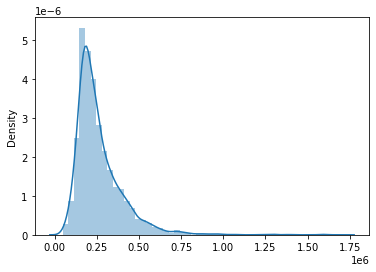

In [12]:
from pyspark.sql.functions import *
df_scp = df_sub.select('SalesClosePrice').toPandas()
sb.distplot(df_scp);

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


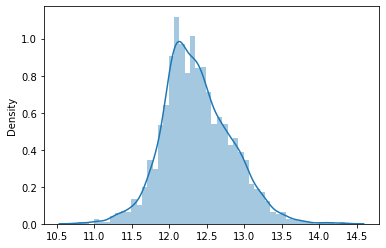

In [13]:
df_log_scp = df_sub.withColumn('log_SalesClosePrice', log(col('SalesClosePrice')))
# df_log_scp
sb.distplot(df_log_scp.select('log_SalesClosePrice').toPandas());

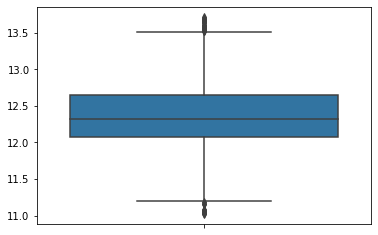

In [14]:
mean_val = df_log_scp.agg({'log_SalesClosePrice': 'mean'}).collect()[0][0]
std_val = df_log_scp.agg({'log_SalesClosePrice': 'stddev'}).collect()[0][0]

high_bound = mean_val + (3 * std_val)
low_bound = mean_val - (3 * std_val)

conditions = (df_log_scp['log_SalesClosePrice'] < high_bound) & (df_log_scp['log_SalesClosePrice'] > low_bound)
df_log_scp_remove_outlier = df_log_scp.where(conditions)

# df_log_scp_remove_outlier.select('log_SalesClosePrice').toPandas().values
sb.boxplot(y = df_log_scp_remove_outlier.select('log_SalesClosePrice').toPandas().values)

In [15]:
df_sub.count()

5000

In [16]:
df_sub = df_sub.dropna()
df_sub.count()

1896

In [17]:
df.count()

5000

In [23]:
df_sub = df.select('STREETNUMBERNUMERIC', 'FIREPLACES', 
                   'LOTSIZEDIMENSIONS', 'LISTTYPE', 'ACRES', 
                   'ASSUMABLEMORTGAGE', 'SalesClosePrice', 'ListPrice',
                   'DAYSONMARKET')
df_sub = df_sub.dropna(thresh=2)
df_sub.count()

5000

In [25]:
max_price = df_sub.agg({'SalesClosePrice': 'max'}).collect()[0][0]
min_price = df_sub.agg({'SalesClosePrice': 'min'}).collect()[0][0]

df_sub = df_sub.withColumn('scaled_price', (df['SalesClosePrice'] - min_price) \
                                            / (max_price - min_price))
max_scaled_price = df_sub.agg({'scaled_price': 'max'}).collect()[0][0]
min_scaled_price = df_sub.agg({'scaled_price': 'min'}).collect()[0][0]

print(max_price)
print(min_price)
print(max_scaled_price)
print(min_scaled_price)

1700000
48000
1.0
0.0


In [31]:
def min_max_scaler(df, col_to_scale):
    for col in col_to_scale:
        max = df.agg({col: 'max'}).collect()[0][0]
        min = df.agg({col: 'min'}).collect()[0][0]
        new_col_name = 'scaled_'+col
        df = df.withColumn(new_col_name, (df[col] - min) \
                                                    / (max - min))
        max_scaled = df.agg({new_col_name: 'max'}).collect()[0][0]
        min_scaled = df.agg({new_col_name: 'min'}).collect()[0][0]
        print('Min-max before scale: {:.2f} - {:.2f}'.format(min, max))
        print('Min-max after scaled: {:.2f} - {:.2f}'.format(min_scaled, max_scaled))
    return df

In [32]:
min_max_scaler(df, ['ListPrice'])

Min-max before scale: 40000.00 - 1850000.00
Min-max after scaled: 0.00 - 1.00


DataFrame[No: int, MLSID: string, StreetNumberNumeric: int, streetaddress: string, STREETNAME: string, PostalCode: int, StateOrProvince: string, City: string, SalesClosePrice: int, LISTDATE: string, LISTPRICE: int, LISTTYPE: string, OriginalListPrice: int, PricePerTSFT: double, FOUNDATIONSIZE: int, FENCE: string, MapLetter: string, LotSizeDimensions: string, SchoolDistrictNumber: string, DAYSONMARKET: int, offmarketdate: string, Fireplaces: int, RoomArea4: string, roomtype: string, ROOF: string, RoomFloor4: string, PotentialShortSale: string, PoolDescription: string, PDOM: int, GarageDescription: string, SQFTABOVEGROUND: int, Taxes: int, RoomFloor1: string, RoomArea1: string, TAXWITHASSESSMENTS: double, TAXYEAR: int, LivingArea: int, UNITNUMBER: string, YEARBUILT: int, ZONING: string, STYLE: string, ACRES: double, CoolingDescription: string, APPLIANCES: string, backonmarketdate: string, ROOMFAMILYCHAR: string, RoomArea3: string, EXTERIOR: string, RoomFloor3: string, RoomFloor2: string,

In [48]:
def std_scaler(df, col_to_scale):
    for col in col_to_scale:
        mean = df.agg({col: 'mean'}).collect()[0][0]
        std = df.agg({col: 'stddev'}).collect()[0][0]
        new_col_name = 'scaled_'+col
        df = df.withColumn(new_col_name, (df[col] - mean)/std)
        mean_scaled = df.agg({new_col_name: 'mean'}).collect()[0][0]
        std_scaled = df.agg({new_col_name: 'stddev'}).collect()[0][0]
        print('Mean-std before scale: {:.2f} - {:.2f}'.format(mean, std))
        print('Mean-std after scaled: {:.2f} - {:.2f}'.format(mean_scaled, std_scaled))
    return df

In [49]:
std_scaler(df, ['ListPrice'])

Mean-std before scale: 263419.36 - 143944.11
Mean-std after scaled: -0.00 - 1.00


DataFrame[No: int, MLSID: string, StreetNumberNumeric: int, streetaddress: string, STREETNAME: string, PostalCode: int, StateOrProvince: string, City: string, SalesClosePrice: int, LISTDATE: string, LISTPRICE: int, LISTTYPE: string, OriginalListPrice: int, PricePerTSFT: double, FOUNDATIONSIZE: int, FENCE: string, MapLetter: string, LotSizeDimensions: string, SchoolDistrictNumber: string, DAYSONMARKET: int, offmarketdate: string, Fireplaces: int, RoomArea4: string, roomtype: string, ROOF: string, RoomFloor4: string, PotentialShortSale: string, PoolDescription: string, PDOM: int, GarageDescription: string, SQFTABOVEGROUND: int, Taxes: int, RoomFloor1: string, RoomArea1: string, TAXWITHASSESSMENTS: double, TAXYEAR: int, LivingArea: int, UNITNUMBER: string, YEARBUILT: int, ZONING: string, STYLE: string, ACRES: double, CoolingDescription: string, APPLIANCES: string, backonmarketdate: string, ROOMFAMILYCHAR: string, RoomArea3: string, EXTERIOR: string, RoomFloor3: string, RoomFloor2: string,

In [42]:
df.where(df['ROOF'].isNull()).count()

765